## Fit a kernel to a signal with random noise, try to remove it.

- Use Celerite2
- Eclipsing binary + Pulsation + noise
- Matern32 kernel (RBF is not available in Celerite2)
- Check that residuals are random noise

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Use Celerite v2
import celerite2
from celerite2 import terms

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilCelerite()

# Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
#df = pd.read_csv("data/sim_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df = pd.read_csv("data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

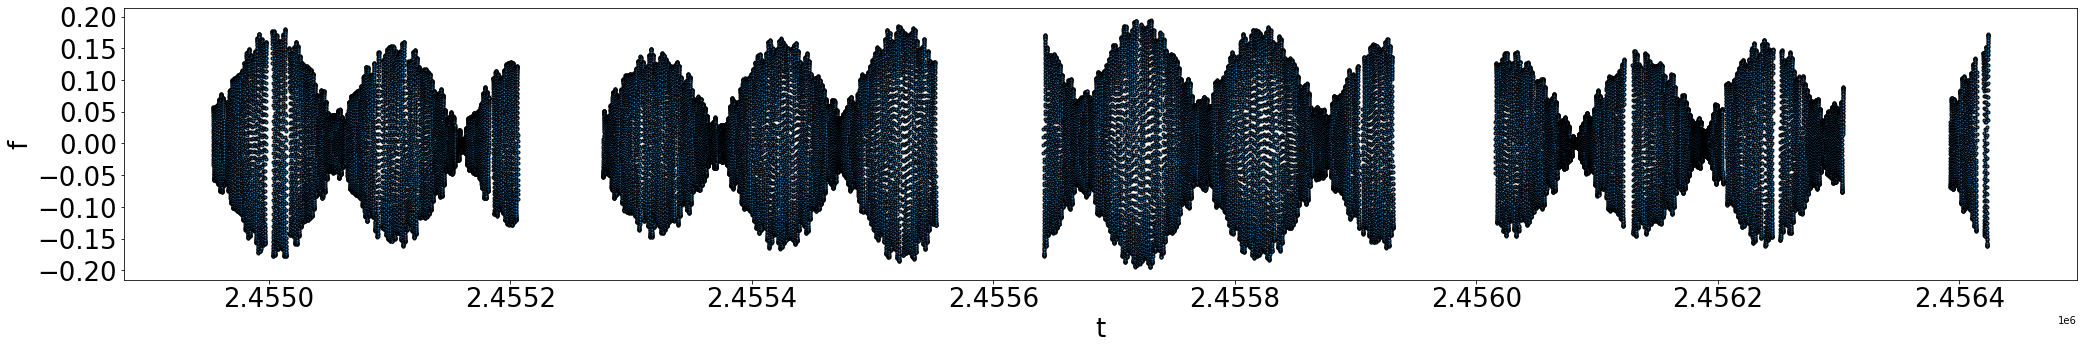

In [5]:
plotter.plot_data(X, Y)

Zoomed in on the first N observations

In [6]:
N_part=11300

In [7]:
X_part=X[:N_part]
Y_part=Y[:N_part]

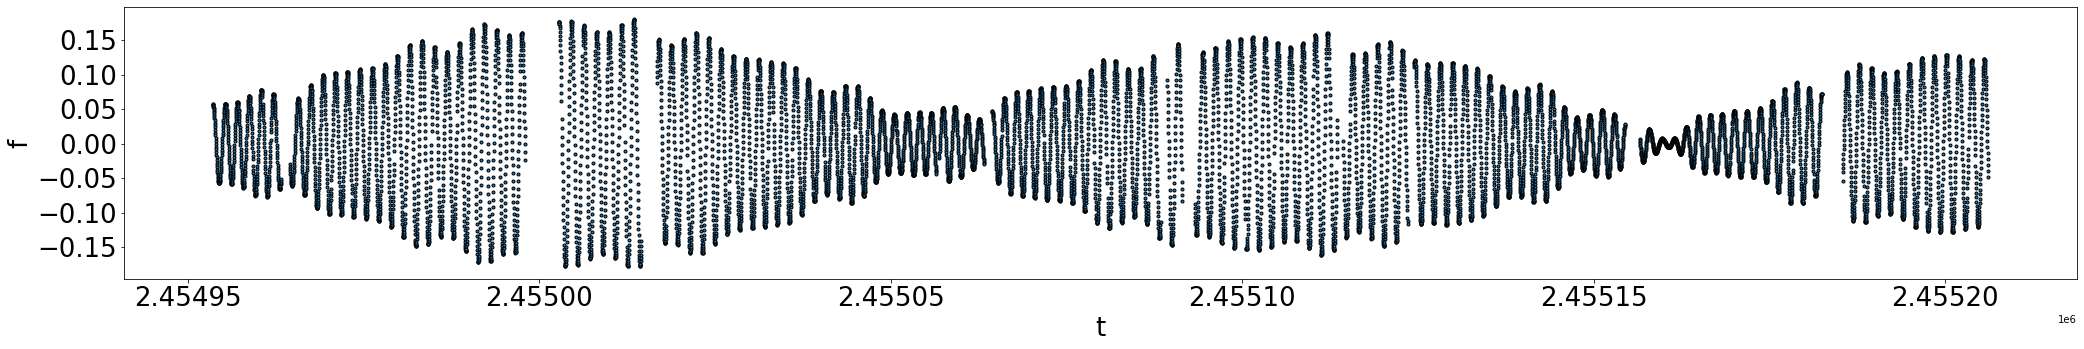

In [8]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [9]:
# normalize the data
_, _, Y_part = experiment_util.normalize_mean(Y_part)

In [10]:
# Add random uncorrelated noise to the data
N_part, YpN_part = experiment_util.generate_random_noise(Y_part)
#yerr = np.random.uniform(Y_part.max()/30, Y_part.max()/10, len(X_part))
#N_part = yerr * np.random.randn(len(X_part))
#YpN_part = Y_part + N_part

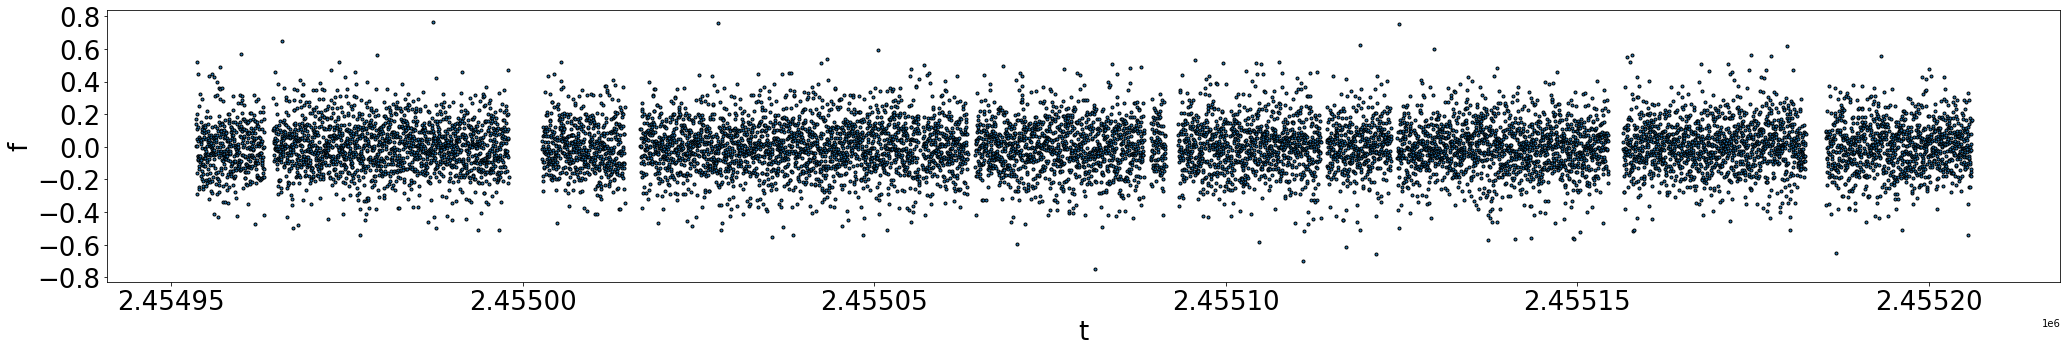

In [11]:
plotter.plot_data(X_part, N_part)

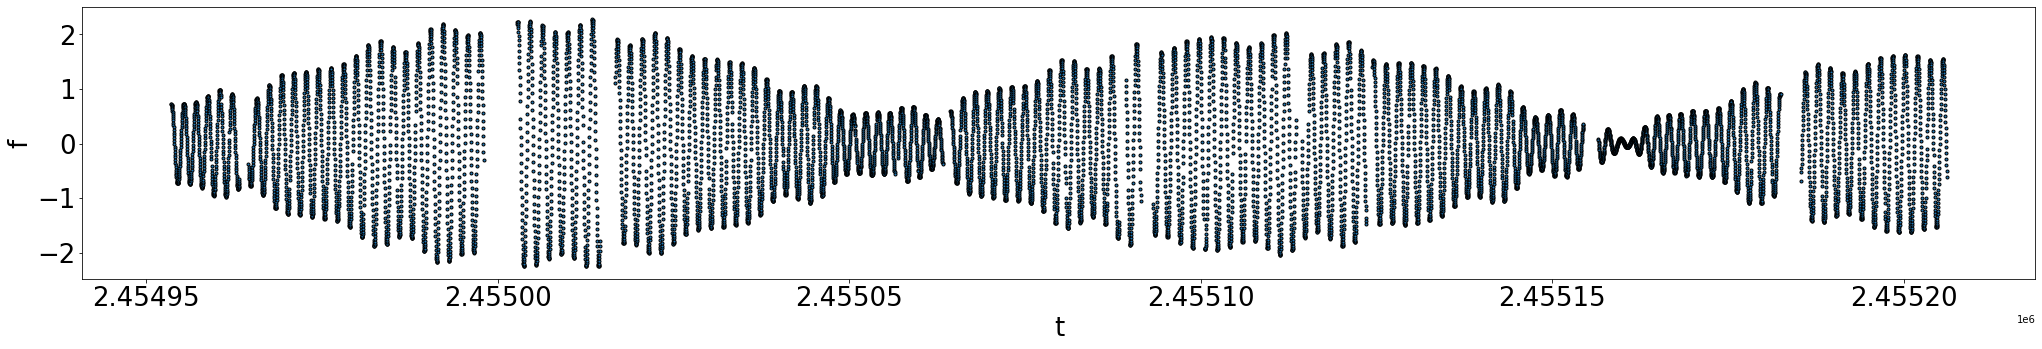

In [12]:
plotter.plot_data(X_part, Y_part)

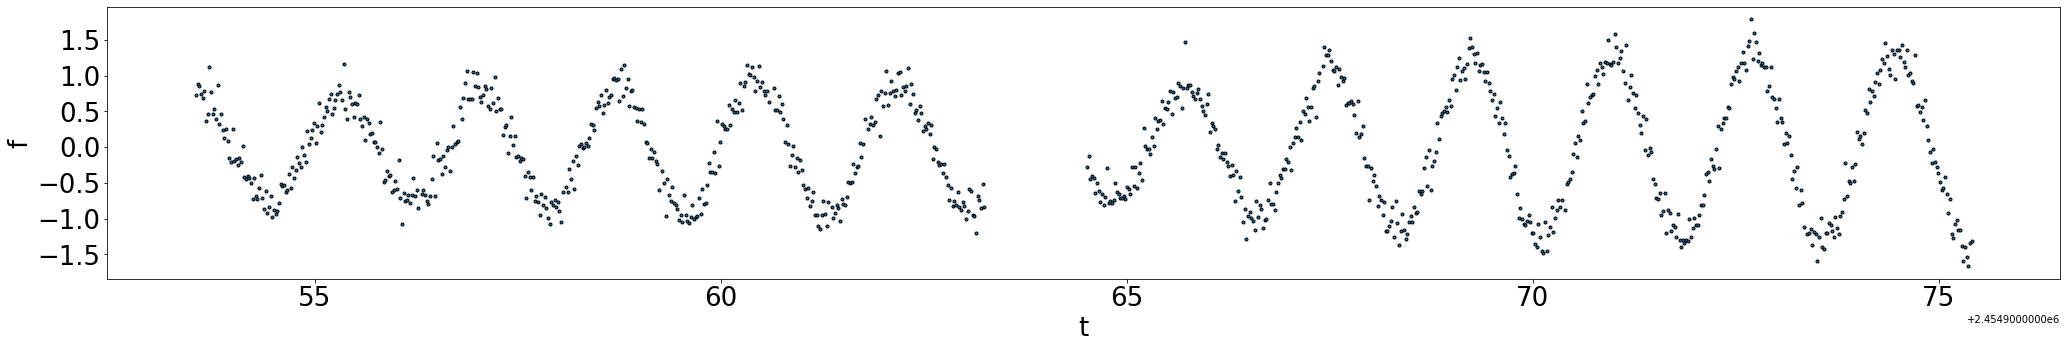

In [13]:
plotter.plot_data(X_part[:1000], YpN_part[:1000])

In [14]:
# Quasi-periodic term
kernel = terms.Matern32Term(sigma=1.0, rho=1.0, eps=10.0)

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(X_part, yerr=0)

print("Initial log likelihood: {0}".format(gp.log_likelihood(YpN_part)))

Initial log likelihood: -299901.66059642605


In [15]:
from scipy.optimize import minimize

yerr=1

def set_params(params, gp, t):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.Matern32Term(sigma=theta[0], rho=theta[1], eps=theta[2])
    gp.compute(t, diag=yerr ** 2 + theta[3], quiet=True)
    return gp


def neg_log_like(params, gp, t, y):
    gp = set_params(params, gp, t)
    return -gp.log_likelihood(y)

# [mean, sigma, rho, eps, ]
# Q2=0.25
initial_params = [0.0, 0.0, 0.0, np.log(10.0), np.log(10.0)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,X_part, YpN_part))
gp = set_params(soln.x, gp, X_part)
soln

      fun: 10693.476644646098
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.56610757e-02,  4.00177669e-03, -1.81898941e-04, -5.48243410e-01,
        0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 510
      nit: 56
     njev: 85
   status: 0
  success: True
        x: array([-1.19976245e-03, -6.78666860e-02,  6.23508344e+00,  1.26664268e+00,
       -1.79967342e+03])

In [16]:
gp.kernel.sigma, gp.kernel.rho, gp.kernel.eps

(0.9343850318853968, 510.34319936313534, 3.5489176850884943)

In [17]:
Y_part_pred, Y_part_pred_var = gp.predict(YpN_part, t=X_part, return_var=True)

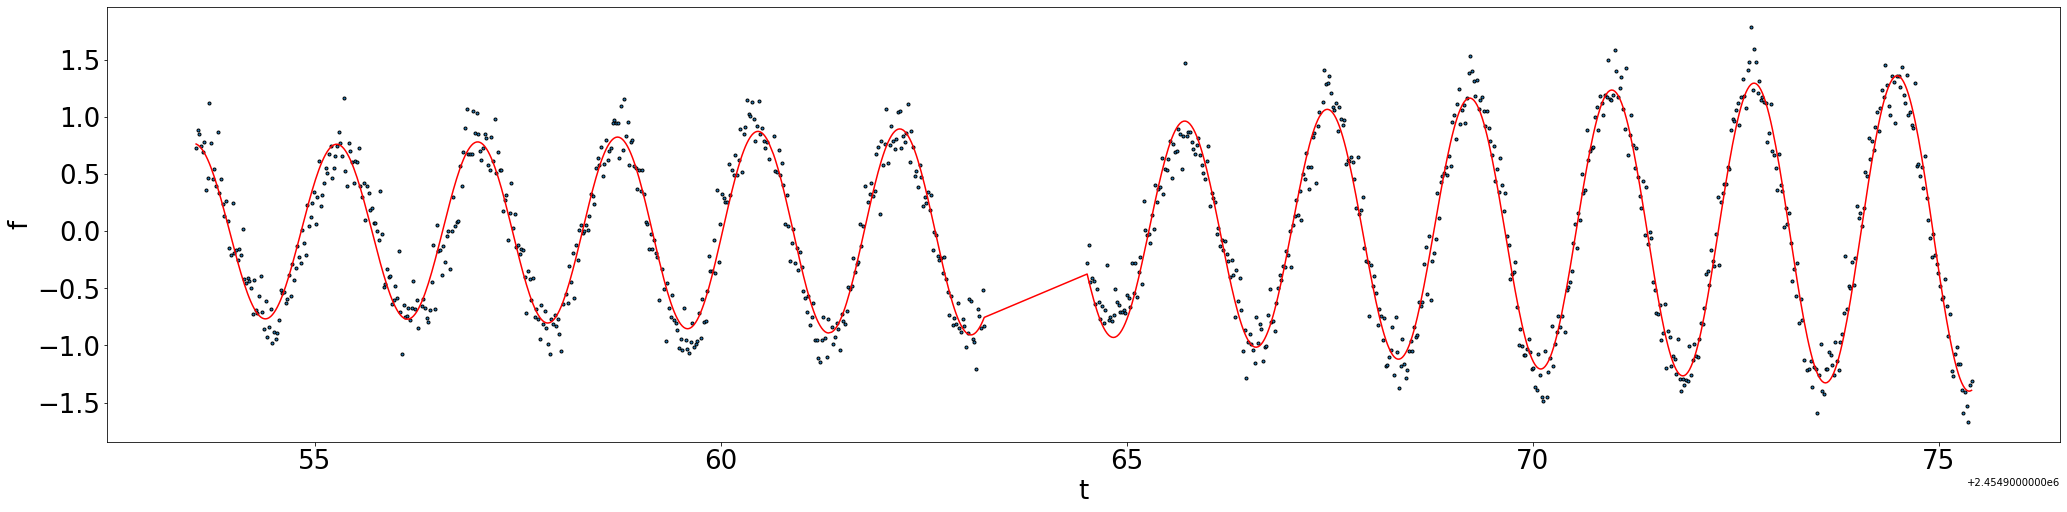

In [18]:
# Plot series with the original X positions
plotter.plot_series(X_part[:1000], YpN_part[:1000], X_part[:1000], Y_part_pred[:1000])

In [19]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_part_pred

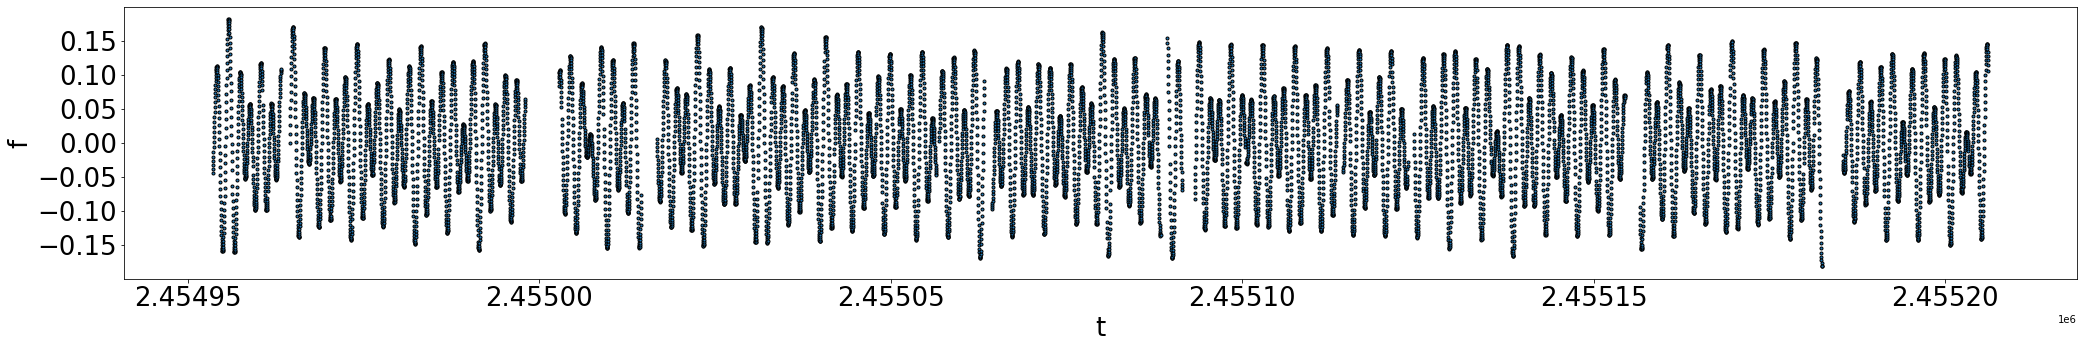

In [20]:
# Plot GP residuals
plotter.plot_data(X_part, residuals)

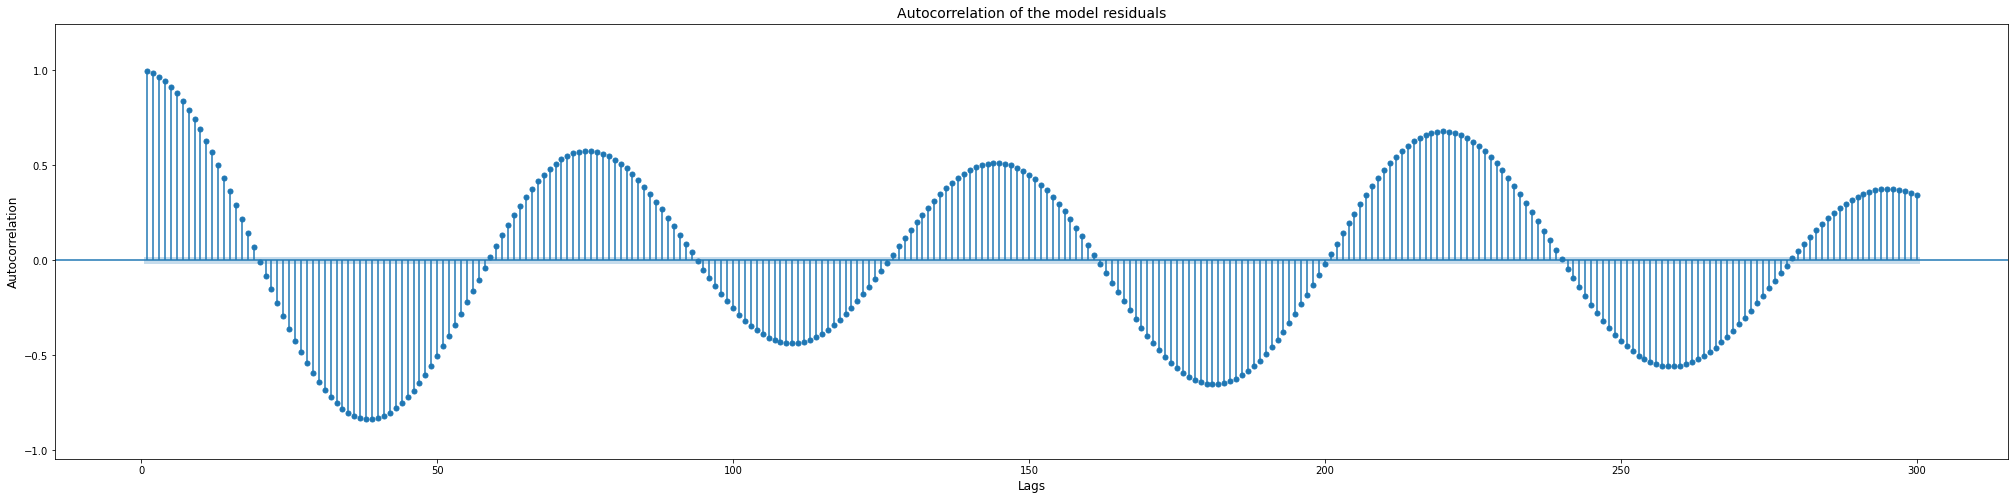

In [21]:
# Now plot the ACF of the residuals. Amplitudes should be under 0.05.
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(35, 8))
# Plot ACF of JPM stock prices for past 40 lags
plot_acf(residuals, lags=300, alpha=1-0.95, zero=False, auto_ylims=True, bartlett_confint=False)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of the model residuals', fontsize=14)
plt.show()

### RMSE

In [22]:
experiment_util.calculate_error(Y_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9970721508930787, rmse=0.07680359462957655)